In [1]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import ffmpeg
from IPython.display import Video
from tqdm import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import logging
from itertools import cycle

logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


plt.style.use('ggplot')
cm = sns.light_palette("green", as_cmap=True)
pd.option_context('display.max_colwidth', 100)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

Histogram Equalization

In [2]:
def plot_img(img_dir,num_items,func,mode):
    img_list = random.sample(os.listdir(img_dir), num_items)

    for i in range(len(img_list)):
        full_path = img_dir + '/' + img_list[i]
        img_temp1 = plt.imread(full_path)
        img_temp_cv = cv2.imread(full_path)
        plt.figure(figsize=(20,15))
        plt.subplot(1,2,1)
        plt.imshow(img_temp1);
        plt.subplot(1,2,2)
        if mode == 'plt':
            plt.imshow(func(img_temp1));
        elif mode == 'cv2':
            plt.imshow(func(img_temp_cv));

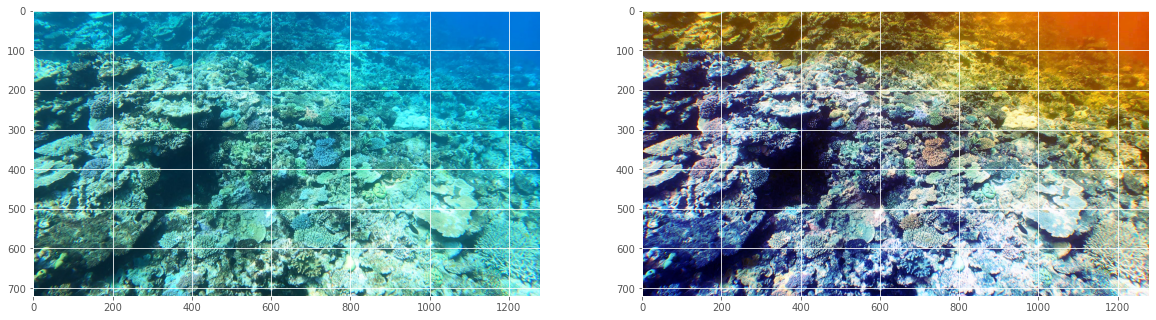

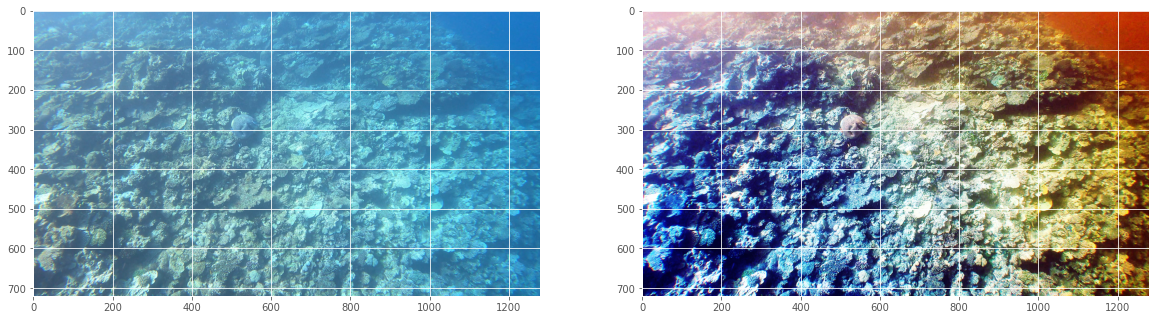

In [3]:
def RecoverHE(sceneRadiance):
    for i in range(3):
        sceneRadiance[:, :, i] =  cv2.equalizeHist(sceneRadiance[:, :, i])
    return sceneRadiance

vid_0_dir = "video_0"
num_items1 = 2
plot_img(vid_0_dir,num_items1,RecoverHE,"cv2")

CLAHE

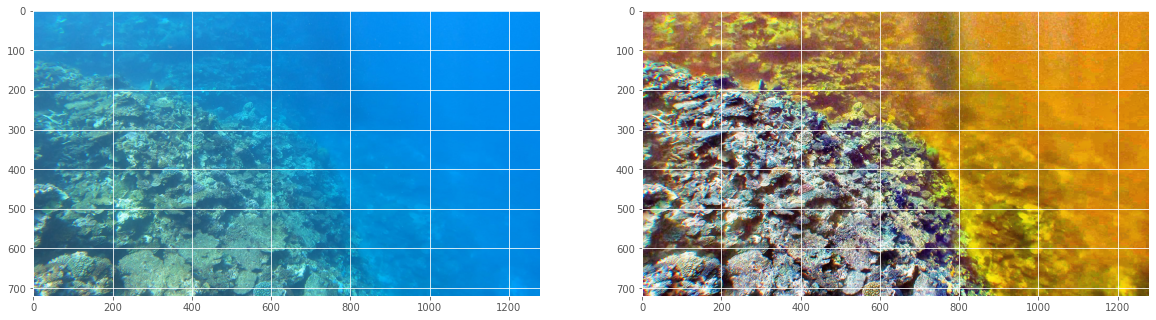

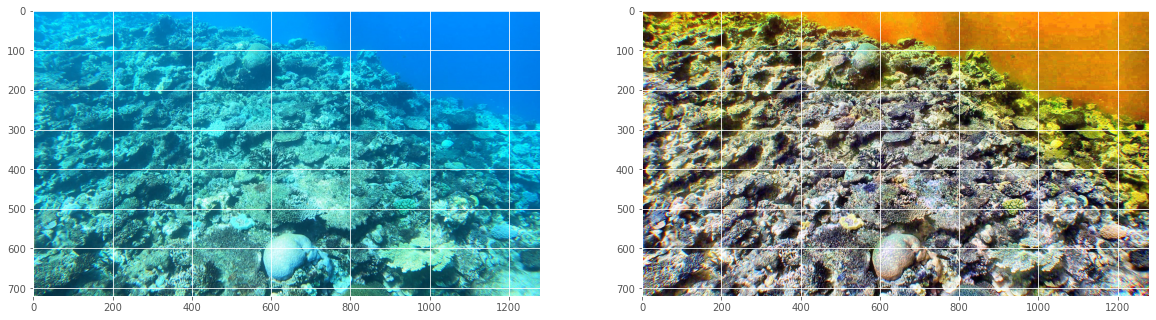

In [4]:
def RecoverCLAHE(sceneRadiance):
    clahe = cv2.createCLAHE(clipLimit=7, tileGridSize=(14, 14))
    for i in range(3):

        
        sceneRadiance[:, :, i] = clahe.apply((sceneRadiance[:, :, i]))


    return sceneRadiance

vid_0_dir = "video_0"
num_items1 = 2
plot_img(vid_0_dir,num_items1,RecoverCLAHE,"cv2")

In [9]:
for i in (os.listdir("video_0")):
    img = cv2.imread(os.path.join("video_0",i))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    processed_img = RecoverCLAHE(img)
    cv2.imwrite("CLAHE/"+i,processed_img)

KeyboardInterrupt: 

GC

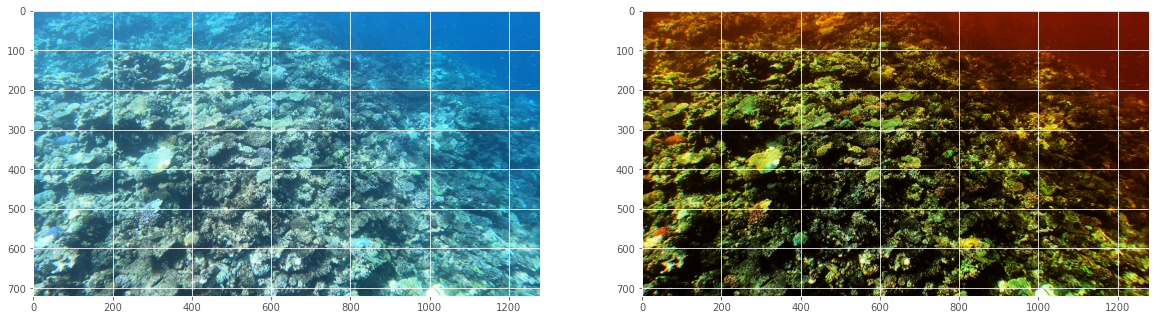

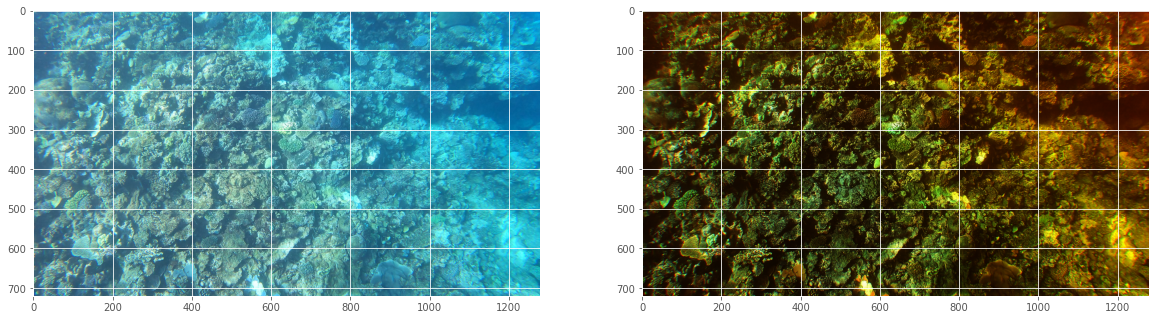

In [6]:
def RecoverGC(sceneRadiance):
    sceneRadiance = sceneRadiance/255.0
    
    for i in range(3):
        sceneRadiance[:, :, i] =  np.power(sceneRadiance[:, :, i] / float(np.max(sceneRadiance[:, :, i])), 3.2)
    sceneRadiance = np.clip(sceneRadiance*255, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)
    return sceneRadiance

vid_0_dir = "video_0"
num_items1 = 2
plot_img(vid_0_dir,num_items1,RecoverGC,"cv2")

ICM

In [7]:
import numpy as np

def global_stretching(img_L,height, width):
    I_min = np.min(img_L)
    I_max = np.max(img_L)
    I_mean = np.mean(img_L)

    array_Global_histogram_stretching_L = np.zeros((height, width))
    for i in range(0, height):
        for j in range(0, width):
            p_out = (img_L[i][j] - I_min) * ((1) / (I_max - I_min))
            array_Global_histogram_stretching_L[i][j] = p_out

    return array_Global_histogram_stretching_L

def stretching(img):
    height = len(img)
    width = len(img[0])
    for k in range(0, 3):
        Max_channel  = np.max(img[:,:,k])
        Min_channel  = np.min(img[:,:,k])
        for i in range(height):
            for j in range(width):
                img[i,j,k] = (img[i,j,k] - Min_channel) * (255 - 0) / (Max_channel - Min_channel)+ 0
    return img

from skimage.color import rgb2hsv,hsv2rgb
import numpy as np



def  HSVStretching(sceneRadiance):
    height = len(sceneRadiance)
    width = len(sceneRadiance[0])
    img_hsv = rgb2hsv(sceneRadiance)
    h, s, v = cv2.split(img_hsv)
    img_s_stretching = global_stretching(s, height, width)

    img_v_stretching = global_stretching(v, height, width)

    labArray = np.zeros((height, width, 3), 'float64')
    labArray[:, :, 0] = h
    labArray[:, :, 1] = img_s_stretching
    labArray[:, :, 2] = img_v_stretching
    img_rgb = hsv2rgb(labArray) * 255

    

    return img_rgb

def sceneRadianceRGB(sceneRadiance):

    sceneRadiance = np.clip(sceneRadiance, 0, 255)
    sceneRadiance = np.uint8(sceneRadiance)

    return sceneRadiance

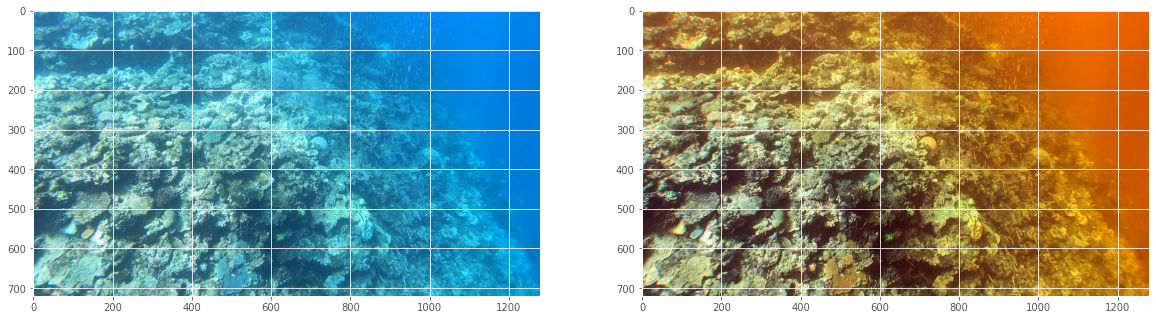

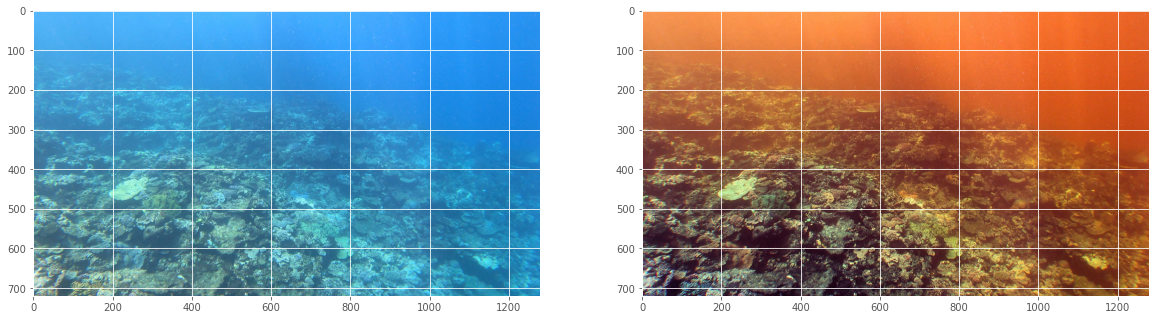

In [8]:
def RecoverICM(img1):
    img = stretching(img1)
    sceneRadiance = sceneRadianceRGB(img)
    sceneRadiance = HSVStretching(sceneRadiance)
    sceneRadiance = sceneRadianceRGB(sceneRadiance)
    
    return sceneRadiance


vid_0_dir = "video_0"
num_items1 = 2
plot_img(vid_0_dir,num_items1,RecoverICM,"cv2")